In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from torchvision.models.video import r3d_18
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


## Dataset & Training Loop

In [3]:
class RandomRotation3D(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        """
        Args:
            img (numpy.ndarray): Input 3D image numpy array.

        Returns:
            numpy.ndarray: Randomly rotated image.
        """
        # Randomly select the rotation angle
        angle = np.random.uniform(-self.degrees, self.degrees)

        # Perform rotation
        rotated_img = np.array([np.rot90(slice, k=int(angle / 90)) for slice in img])

        return rotated_img

train_transform = transforms.Compose([
    RandomRotation3D(degrees=5)
])


class AbdominalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Select only the last 64 slices: 
        resized_image = resized_image[-64:, :, :]

        if self.transform:
            resized_image = self.transform(resized_image)
            
        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

    
        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()

        sample = {'x': image, 'y': label}
        return sample



In [4]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, verbose=False):
    acc_dict = {'train': [], 'validate': []}
    loss_dict = {'train': [], 'validate': []}
    best_loss = 1e30
    phases = ['train', 'validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs - 1))
        print('-' * 10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()
                image, label = data['x'], data['y']
                image = image.to(device)
                label = label.to(device)
                outputs = model(image)
                loss = loss_fn(outputs.squeeze(),  label.float())  # Squeeze the output to remove the extra dimension

                if p == 'train':
                    loss.backward()
                    optimizer.step()
                preds = torch.round(torch.sigmoid(outputs)).squeeze()  # Round the sigmoid output to get 0 or 1
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds == label).item()
                running_loss += loss.item() * num_imgs
                running_total += num_imgs

            epoch_acc = float(running_correct / running_total)
            epoch_loss = float(running_loss / running_total)
            if verbose or (i % 10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))

            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    # Calculate F1 score for the validation set
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for data in dataloader['validate']:
            optimizer.zero_grad()
            image, label = data['x'], data['y']
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            preds = torch.round(torch.sigmoid(outputs))  # Round the sigmoid output to get 0 or 1
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(label.cpu().numpy())
            
    val_f1 = f1_score(val_labels, val_preds)

    print('Best F1: {:4f}'.format(val_f1))

    return model, acc_dict, loss_dict


## ResNet18-3D Model

In [5]:
class ResNet18_3D(nn.Module):
    def __init__(self, dropout=0.1):
        super(ResNet18_3D, self).__init__()
        self.resnet18_3d = r3d_18(weights='DEFAULT')

        # Modify stem layer to accept single-channel input
        self.resnet18_3d.stem = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        
        # Change the last fully connected layer
        self.resnet18_3d.fc = nn.Linear(self.resnet18_3d.fc.in_features, 1)
        
        # Add Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Add Batch Normalization
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm3d(64),
            nn.BatchNorm3d(64),
            nn.BatchNorm3d(128),
            nn.BatchNorm3d(256),
            nn.BatchNorm3d(512)
        ])
        
        # Adaptive average pooling
        self.adaptive_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        # Flatten
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.resnet18_3d.stem(x)
        x = self.batch_norms[0](x)
        x = self.resnet18_3d.layer1(x)
        x = self.batch_norms[1](x)
        x = self.resnet18_3d.layer2(x)
        x = self.batch_norms[2](x)
        x = self.resnet18_3d.layer3(x)
        x = self.batch_norms[3](x)
        x = self.resnet18_3d.layer4(x)
        x = self.batch_norms[4](x)
        x = self.adaptive_avg_pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.resnet18_3d.fc(x)
        
        return x

## Hyperparameter Tuning

In [6]:
#TESTING LR AND BATCH SIZE:
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [8, 16]

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

models = []
acc_dicts = []
loss_dicts = []

for l in learning_rates:
    for bs in batch_sizes:
        print('Learning Rate:', l)
        print('Batch Size:', bs)
        
        model = ResNet18_3D().to(device)

        pos_weight = torch.tensor(10.0).to(device)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight, reduction='mean')

        optimizer = optim.Adam(model.parameters(), lr=l, weight_decay=1e-4)

        dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_sample_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/', train_transform), 
                   'validate': AbdominalDataset(os.path.join(data_directory, 'val_sample_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/'),
                   'test': AbdominalDataset(os.path.join(data_directory, 'test_sample_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')}
        
        dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                                shuffle=True) for x in ['train', 'validate']}

        model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs=10, verbose=True)
        models.append(model)
        acc_dicts.append(acc_dict)
        loss_dicts.append(loss_dict)


Learning Rate: 0.001
Batch Size: 8
Epoch: 0/9
----------
Phase:train, epoch loss: 1.3616 Acc: 0.5638
Phase:validate, epoch loss: 2.1287 Acc: 0.8723
Epoch: 1/9
----------
Phase:train, epoch loss: 1.1246 Acc: 0.5904
Phase:validate, epoch loss: 1.6748 Acc: 0.6649
Epoch: 2/9
----------
Phase:train, epoch loss: 1.0327 Acc: 0.6117
Phase:validate, epoch loss: 2.1607 Acc: 0.8617
Epoch: 3/9
----------
Phase:train, epoch loss: 0.8922 Acc: 0.6330
Phase:validate, epoch loss: 3.1931 Acc: 0.2394
Epoch: 4/9
----------
Phase:train, epoch loss: 0.9793 Acc: 0.6809
Phase:validate, epoch loss: 3.3188 Acc: 0.8723
Epoch: 5/9
----------
Phase:train, epoch loss: 0.9254 Acc: 0.7128
Phase:validate, epoch loss: 4.7192 Acc: 0.2021
Epoch: 6/9
----------
Phase:train, epoch loss: 0.8500 Acc: 0.7394
Phase:validate, epoch loss: 1.7068 Acc: 0.7606
Epoch: 7/9
----------
Phase:train, epoch loss: 0.7281 Acc: 0.7606
Phase:validate, epoch loss: 13.0030 Acc: 0.1809
Epoch: 8/9
----------
Phase:train, epoch loss: 0.8947 Acc: 0

In [7]:
# Save models
with open('models_hyperparameter_resnet.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save acc_dicts
with open('acc_dicts_hyperparameter_resnet.pkl', 'wb') as f:
    pickle.dump(acc_dicts, f)

# Save loss_dicts
with open('loss_dicts_hyperparameter_resnet.pkl', 'wb') as f:
    pickle.dump(loss_dicts, f)

In [8]:
# Load models
with open('models_hyperparameter_resnet.pkl', 'rb') as f:
    models = pickle.load(f)

# Load acc_dicts
with open('acc_dicts_hyperparameter_resnet.pkl', 'rb') as f:
    acc_dicts = pickle.load(f)

# Load loss_dicts
with open('loss_dicts_hyperparameter_resnet.pkl', 'rb') as f:
    loss_dicts = pickle.load(f)

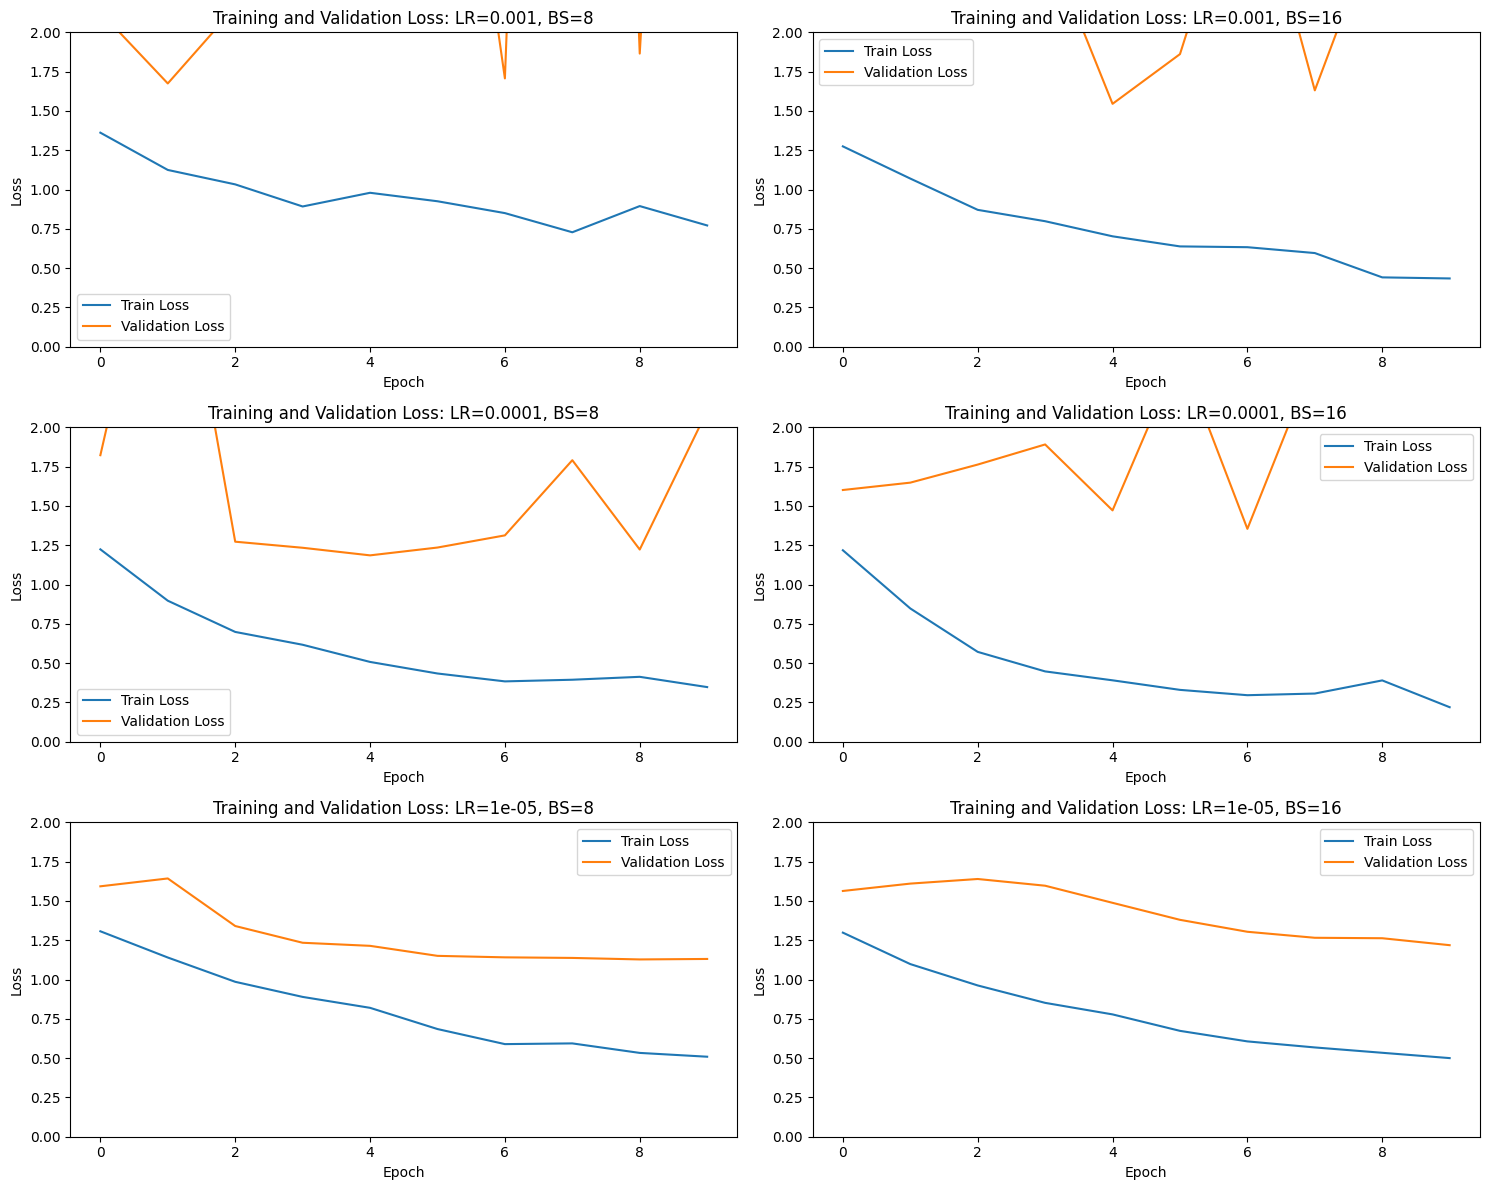

In [9]:
#LOSS:
fig, axs = plt.subplots(len(learning_rates), len(batch_sizes), figsize=(15, 12))
idx = 0
for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        loss_dict = loss_dicts[idx]
        model = models[idx]

        axs[i, j].plot(range(0,len(loss_dict['train'])),loss_dict['train'], label='Train Loss')
        axs[i, j].plot(range(0,len(loss_dict['validate'])),loss_dict['validate'], label='Validation Loss')
        axs[i, j].set_title(f'Training and Validation Loss: LR={lr}, BS={bs}')
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].set_ylabel('Loss')
        axs[i,j].set_ylim(0,2)
        axs[i, j].legend()
        idx += 1


plt.tight_layout()
plt.show()



In [10]:
def evaluate_hyperparameter_tuning(model, dataloader, device):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([])  # To store predicted probabilities
    all_preds = np.array([])  # To store predicted class labels
    
    with torch.no_grad():
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            
            probs = torch.sigmoid(outputs).squeeze(1)
            preds = torch.round(probs) 
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)  # Use probabilities for the positive class
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate AUC score
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)

     # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate FNR and FPR
    fnr = fn / (fn + tp)
    fpr = fp / (tn + fp)

    # Calculate AUPRC score
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    auprc_score = average_precision_score(all_labels, all_probs)

    return f1, auc_score, auprc_score, fnr, fpr

hyperparam_eval_dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['validate']}
idx = 0

for i, l in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        model = models[idx]
        f1, auc_score, auprc_score, fnr, fpr = evaluate_hyperparameter_tuning(model, hyperparam_eval_dataloader['validate'], device)
        idx += 1
        print("Learning Rate:", l, "Batch Size:", bs, "Val F1:", f1, "Val AUC:", auc_score, "Val AUPRC:", auprc_score, "Val FNR", fnr, "Val FPR", fpr)

Learning Rate: 0.001 Batch Size: 8 Val F1: 0.24096385542168675 Val AUC: 0.6476117886178862 Val AUPRC: 0.17482301198909297 Val FNR 0.5833333333333334 Val FPR 0.29878048780487804
Learning Rate: 0.001 Batch Size: 16 Val F1: 0.3119266055045872 Val AUC: 0.6910569105691058 Val AUPRC: 0.23270675943243121 Val FNR 0.2916666666666667 Val FPR 0.4146341463414634
Learning Rate: 0.0001 Batch Size: 8 Val F1: 0.3917525773195876 Val AUC: 0.7954776422764228 Val AUPRC: 0.42202615510449815 Val FNR 0.20833333333333334 Val FPR 0.32926829268292684
Learning Rate: 0.0001 Batch Size: 16 Val F1: 0.3130434782608696 Val AUC: 0.7578760162601627 Val AUPRC: 0.3048624041831181 Val FNR 0.25 Val FPR 0.4451219512195122
Learning Rate: 1e-05 Batch Size: 8 Val F1: 0.33663366336633666 Val AUC: 0.8183434959349594 Val AUPRC: 0.5383161699021725 Val FNR 0.2916666666666667 Val FPR 0.36585365853658536
Learning Rate: 1e-05 Batch Size: 16 Val F1: 0.352 Val AUC: 0.7751524390243902 Val AUPRC: 0.2860994538621507 Val FNR 0.0833333333333

## Train Full Model

In [11]:
bs = 8
lr = 0.0001

model = ResNet18_3D().to(device)

pos_weight = torch.tensor(10.0).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight, reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/', train_transform), 
           'validate': AbdominalDataset(os.path.join(data_directory, 'val_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/'),
           'test': AbdominalDataset(os.path.join(data_directory, 'test_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')}

dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True) for x in ['train', 'validate']}

model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs=10, verbose=True)


Epoch: 0/9
----------
Phase:train, epoch loss: 1.2651 Acc: 0.5281
Phase:validate, epoch loss: 1.5013 Acc: 0.8447
Epoch: 1/9
----------
Phase:train, epoch loss: 1.2240 Acc: 0.5563
Phase:validate, epoch loss: 1.2205 Acc: 0.5191
Epoch: 2/9
----------
Phase:train, epoch loss: 1.1882 Acc: 0.5701
Phase:validate, epoch loss: 1.3967 Acc: 0.3298
Epoch: 3/9
----------
Phase:train, epoch loss: 1.1377 Acc: 0.5918
Phase:validate, epoch loss: 1.2053 Acc: 0.5021
Epoch: 4/9
----------
Phase:train, epoch loss: 1.0908 Acc: 0.6165
Phase:validate, epoch loss: 1.2160 Acc: 0.5447
Epoch: 5/9
----------
Phase:train, epoch loss: 1.0096 Acc: 0.6385
Phase:validate, epoch loss: 1.1841 Acc: 0.7255
Epoch: 6/9
----------
Phase:train, epoch loss: 0.9466 Acc: 0.6797
Phase:validate, epoch loss: 1.5777 Acc: 0.3234
Epoch: 7/9
----------
Phase:train, epoch loss: 0.7456 Acc: 0.7476
Phase:validate, epoch loss: 1.7723 Acc: 0.3681
Epoch: 8/9
----------
Phase:train, epoch loss: 0.5865 Acc: 0.8129
Phase:validate, epoch loss: 1.

In [12]:
torch.save(model.state_dict(), 'classification_model_resnet18_cropped_binary_0_9_final.pth')

In [13]:
with open('acc_dict_resnet18_cropped_binary_0_9_final.pickle', 'wb') as handle:
    pickle.dump(acc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('loss_dict_resnet18_cropped_binary_0_9_final.pickle', 'wb') as handle:
    pickle.dump(loss_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluate Model

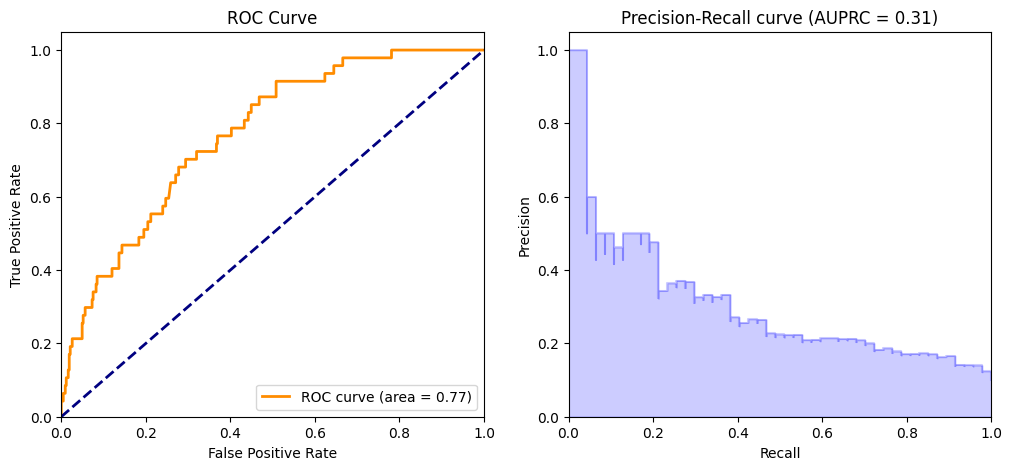

Test F1: 0.3157894736842105
Test AUC: 0.7700625782227785
Test AUPRC: 0.30971049349661534
Test FNR: 0.3617021276595745
Test FPR: 0.26588235294117646


In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([])  # To store predicted probabilities
    all_preds = np.array([])  # To store predicted class labels
    
    with torch.no_grad():
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            probs = torch.sigmoid(outputs).squeeze()
            preds = torch.round(probs) 
            
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate FNR and FPR
    fnr = fn / (fn + tp)
    fpr = fp / (tn + fp)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate AUC score
    fprs, tprs, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fprs, tprs)
    
    # Calculate AUPRC score
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    auprc_score = average_precision_score(all_labels, all_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(fprs, tprs, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (AUPRC = %0.2f)' % auprc_score)
    
    plt.show()
        
    return f1, auc_score, auprc_score, fnr, fpr

eval_dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['test']}

test_f1, test_auc, test_auprc, test_fnr, test_fpr = evaluate_model(model, eval_dataloader['test'], device)
print("Test F1:", test_f1)
print("Test AUC:", test_auc)
print("Test AUPRC:", test_auprc)
print("Test FNR:", test_fnr)
print("Test FPR:", test_fpr)
